In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import geopy
import sklearn
from sklearn import metrics
import holidays

## Load data

In [2]:
import json

with open('data/query_prediction/data.json') as json_file:
    data = json.load(json_file)

In [3]:
arrival_df = pd.DataFrame(data)

In [4]:
arrival_df['time_plan_ts'] = pd.to_datetime(arrival_df.time_plan).dt.tz_localize(None) + pd.Timedelta(3, 'h')
arrival_df['time_fact_ts'] = pd.to_datetime(arrival_df.time_fact).dt.tz_localize(None) + pd.Timedelta(3, 'h')

# arrival_df = arrival_df.sort_values('time_plan').reset_index()

In [5]:
arrival_df.shape

(89254, 16)

In [6]:
arrival_df.date.unique()

array(['2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
       '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
       '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
       '2020-11-27', '2020-11-28', '2020-11-29'], dtype=object)

In [7]:
route_uuid = arrival_df.route_uuid.unique()[1]
vehicle_uuid = arrival_df.vehicle_uuid.unique()[5]
# dates = ['2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21']
dates = arrival_df.date.unique()#[:10]
date_test = '2020-11-22'

df_sample = arrival_df[
    (arrival_df.route_uuid == route_uuid) &
    (arrival_df.vehicle_uuid == vehicle_uuid) 
    & (arrival_df.date.isin(dates))
].sort_values('time_plan')

df_sample = df_sample.iloc[0:].reset_index().drop('index', axis=1)

In [8]:
labels = [str(i) + '-' + str(j) for (i,j) in zip(np.arange(0, 26, 2), np.arange(0, 26, 2)[1:])]
df_sample['time_bin'] = pd.cut(df_sample.time_plan_ts.dt.hour,
                        bins=np.arange(0, 26, 2),
                        include_lowest=True,
                        labels=labels).astype(str)

df_sample['weekday'] = df_sample.time_plan_ts.apply(lambda x: x.weekday()).astype(str)

holiday_dates = [str(h) for h in holidays.Russia(years=2020)]
df_sample['is_holiday'] = df_sample.date.apply(lambda x: x in holiday_dates).astype(int)

df_sample['is_weekend'] = df_sample.weekday.isin({5,6}).astype(int)

## To timeseries format

In [9]:
stops = df_sample.apply(lambda x: str(x.latitude) + ' - ' + str(x.longitude), axis=1)

ind2stop = dict(enumerate(stops.unique()))
stop2ind = {s:i for i,s in ind2stop.items()}

df_sample['stop_number'] = stops.apply(lambda x: stop2ind[x])

In [10]:
df_sample['plan_time_to_next_stop'] = (df_sample.time_plan_ts.shift(-1) - df_sample.time_plan_ts).apply(lambda x: x.total_seconds())
df_sample.plan_time_to_next_stop = df_sample.plan_time_to_next_stop.fillna(method='ffill')

df_sample['fact_time_to_next_stop'] = (df_sample.time_fact_ts.shift(-1) - df_sample.time_fact_ts).apply(lambda x: x.total_seconds())
df_sample.fact_time_to_next_stop = df_sample.fact_time_to_next_stop.fillna(df_sample.plan_time_to_next_stop)
df_sample['time_off'] = df_sample.fact_time_to_next_stop - df_sample.plan_time_to_next_stop

In [11]:
df_sample.head()

order_uuid                  order_execution_uuid  \
0  aa7badb2-2472-11eb-a7e7-02f42b90d40c  aadd8654-2472-11eb-8216-02f42b90d40c   
1  aa7badb2-2472-11eb-a7e7-02f42b90d40c  aadd8654-2472-11eb-8216-02f42b90d40c   
2  aa7badb2-2472-11eb-a7e7-02f42b90d40c  aadd8654-2472-11eb-8216-02f42b90d40c   
3  aa7badb2-2472-11eb-a7e7-02f42b90d40c  aadd8654-2472-11eb-8216-02f42b90d40c   
4  aa7badb2-2472-11eb-a7e7-02f42b90d40c  aadd8654-2472-11eb-8216-02f42b90d40c   

         order_execution_data_item_uuid                            route_uuid  \
0  ab1af520-2472-11eb-af58-02f42b90d40c  243289fe-ec14-11e7-9143-fd1bc5b80199   
1  ab1fa246-2472-11eb-bee2-02f42b90d40c  243289fe-ec14-11e7-9143-fd1bc5b80199   
2  ab2311ce-2472-11eb-b676-02f42b90d40c  243289fe-ec14-11e7-9143-fd1bc5b80199   
3  ab25ad26-2472-11eb-bd62-02f42b90d40c  243289fe-ec14-11e7-9143-fd1bc5b80199   
4  ab292e06-2472-11eb-a470-02f42b90d40c  243289fe-ec14-11e7-9143-fd1bc5b80199   

                                          route_name  \
0  Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
1  Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
2  Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
3  Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
4  Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   

                           vehicle_uuid                type  turn  \
0  84b21508-ce8f-11e7-b61c-91326936c687  production_forward    16   
1  84b21508-ce8f-11e7-b61c-91326936c687  production_forward    16   
2  84b21508-ce8f-11e7-b61c-91326936c687  production_forward    16   
3  84b21508-ce8f-11e7-b61c-91326936c687  production_forward    16   
4  84b21508-ce8f-11e7-b61c-91326936c687  production_forward    16   

                              type_uuid  longitude  ...        time_plan_ts  \
0  22c39fcc-eb47-11e7-9fcf-497e33472986  37.409556  ... 2020-11-15 07:29:00   
1  22e3318e-eb47-11e7-8fa0-6782feb69c31  37.405265  ... 2020-11-15 07:30:00   
2  22f28670-eb47-11e7-8553-4dc40069e92a  37.404445  ... 2020-11-15 07:31:00   
3  25a64348-eb47-11e7-990e-8da554ce69d8  37.410239  ... 2020-11-15 07:34:00   
4  25b5b0d0-eb47-11e7-ad72-b3d3ebe2afff  37.415091  ... 2020-11-15 07:35:00   

         time_fact_ts time_bin weekday is_holiday is_weekend stop_number  \
0 2020-11-15 07:30:41      6-8       6          0          0           0   
1 2020-11-15 07:31:51      6-8       6          0          0           1   
2 2020-11-15 07:33:01      6-8       6          0          0           2   
3 2020-11-15 07:35:10      6-8       6          0          0           3   
4 2020-11-15 07:36:11      6-8       6          0          0           4   

  plan_time_to_next_stop  fact_time_to_next_stop  time_off  
0                   60.0                    70.0      10.0  
1                   60.0                    70.0      10.0  
2                  180.0                   129.0     -51.0  
3                   60.0                    61.0       1.0  
4                  120.0                   130.0      10.0  

[5 rows x 24 columns]

In [12]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataframe, col):
    df = dataframe.copy()
    oh = OneHotEncoder()
    array = oh.fit_transform(df[col].values.reshape((-1, 1))).toarray()
    cols = [col + '_' + str(i) for i in range(array.shape[1])]
    df[cols] = array
    return df.drop(col, axis=1)

In [13]:
encoded = df_sample[['time_off', 'plan_time_to_next_stop', 'fact_time_to_next_stop', 'time_bin', 'stop_number', 'weekday', 'is_weekend', 'is_holiday', 'date']].iloc[:-1]

In [14]:
# encoded.to_csv('data/sample2_cat.csv', index=False)

In [15]:
encoded = one_hot_encode(encoded, 'date')
encoded = one_hot_encode(encoded, 'time_bin')
encoded = one_hot_encode(encoded, 'stop_number')
encoded = one_hot_encode(encoded, 'weekday')
# encoded = one_hot_encode(encoded, 'is_weekend')
# encoded = one_hot_encode(encoded, 'is_holiday')

In [16]:
def df_to_supervized(series, columns, num_recent, fillna_method='mean'):
    df = series.copy()
    for col, num in zip(columns, num_recent):
        if sum(df[col].isna() > 0):
            indicator = col + '_isna'
            df[indicator] = df[col].isna().astype(int)
            if fillna_method == 'mean':
                method = df[col].mean()
            else:
                method = fillna_method
            df[col] = df[col].fillna(method)

        for i in range(num):
            col_name = col + '_-' + str(i+1)
            df[col_name] = df[col].shift(i+1)
    
    return df.iloc[max(num_recent):]

In [17]:
encoded.columns

Index(['time_off', 'plan_time_to_next_stop', 'fact_time_to_next_stop',
       'is_weekend', 'is_holiday', 'date_0', 'date_1', 'date_2', 'date_3',
       'date_4', 'date_5', 'date_6', 'date_7', 'date_8', 'date_9', 'date_10',
       'date_11', 'time_bin_0', 'time_bin_1', 'time_bin_2', 'time_bin_3',
       'time_bin_4', 'time_bin_5', 'time_bin_6', 'time_bin_7', 'time_bin_8',
       'time_bin_9', 'time_bin_10', 'stop_number_0', 'stop_number_1',
       'stop_number_2', 'stop_number_3', 'stop_number_4', 'stop_number_5',
       'stop_number_6', 'stop_number_7', 'stop_number_8', 'stop_number_9',
       'stop_number_10', 'stop_number_11', 'stop_number_12', 'stop_number_13',
       'stop_number_14', 'stop_number_15', 'stop_number_16', 'stop_number_17',
       'stop_number_18', 'stop_number_19', 'stop_number_20', 'stop_number_21',
       'stop_number_22', 'stop_number_23', 'stop_number_24', 'stop_number_25',
       'stop_number_26', 'stop_number_27', 'stop_number_28', 'stop_number_29',
       'st

### Drop peaks 

In [18]:
peaks_index = encoded.loc[encoded.plan_time_to_next_stop > 10 * 60].index

In [19]:
encoded = encoded.drop(peaks_index)

In [122]:
cols = encoded.columns
nums = [0, 8, 5]

supervized = df_to_supervized(encoded, cols, nums, fillna_method='mean')
# supervized['resting_estimate_09'] = supervized.plan_time_to_next_stop.apply(lambda x: 0 if x < 60 * 20 else x * 0.9)
# supervized['resting_estimate_08'] = supervized.plan_time_to_next_stop.apply(lambda x: 0 if x < 60 * 20 else x * 0.8)
# supervized['resting_estimate_07'] = supervized.plan_time_to_next_stop.apply(lambda x: 0 if x < 60 * 20 else x * 0.7)
# supervized['resting_indicator'] = supervized.plan_time_to_next_stop.apply(lambda x: x > 60 * 20).astype(int)
# supervized['wait_point_indicator'] = supervized.plan_time_to_next_stop.apply(lambda x: x > 60 * 9).astype(int)

# test = supervized[supervized.date.isin(supervized.date.unique()[:1])].drop('date', axis=1)
# train = supervized[supervized.date.isin(supervized.date.unique()[1:])].drop('date', axis=1)

test = supervized[(supervized.date_0 == 1) | (supervized.date_1 == 1)]
test1 = supervized[(supervized.date_0 == 1)]
test2 = supervized[(supervized.date_1 == 1)]
train = supervized[(supervized.date_0 == 0) & (supervized.date_1 == 0)]

In [123]:
test.shape

(647, 83)

In [124]:
train.shape

(1997, 83)

In [125]:
supervized.head()

time_off  plan_time_to_next_stop  fact_time_to_next_stop  is_weekend  \
8       59.0                    60.0                   119.0           0   
9       11.0                   120.0                   131.0           0   
10     -71.0                   120.0                    49.0           0   
11     -89.0                   180.0                    91.0           0   
12     -20.0                   120.0                   100.0           0   

    is_holiday  date_0  date_1  date_2  date_3  date_4  ...  \
8            0     1.0     0.0     0.0     0.0     0.0  ...   
9            0     1.0     0.0     0.0     0.0     0.0  ...   
10           0     1.0     0.0     0.0     0.0     0.0  ...   
11           0     1.0     0.0     0.0     0.0     0.0  ...   
12           0     1.0     0.0     0.0     0.0     0.0  ...   

    plan_time_to_next_stop_-4  plan_time_to_next_stop_-5  \
8                       120.0                       60.0   
9                        60.0                      120.0   
10                       60.0                       60.0   
11                      120.0                       60.0   
12                       60.0                      120.0   

    plan_time_to_next_stop_-6  plan_time_to_next_stop_-7  \
8                       180.0                       60.0   
9                        60.0                      180.0   
10                      120.0                       60.0   
11                       60.0                      120.0   
12                       60.0                       60.0   

    plan_time_to_next_stop_-8  fact_time_to_next_stop_-1  \
8                        60.0                      150.0   
9                        60.0                      119.0   
10                      180.0                      131.0   
11                       60.0                       49.0   
12                      120.0                       91.0   

    fact_time_to_next_stop_-2  fact_time_to_next_stop_-3  \
8                       121.0                       89.0   
9                       150.0                      121.0   
10                      119.0                      150.0   
11                      131.0                      119.0   
12                       49.0                      131.0   

    fact_time_to_next_stop_-4  fact_time_to_next_stop_-5  
8                       130.0                       61.0  
9                        89.0                      130.0  
10                      121.0                       89.0  
11                      150.0                      121.0  
12                      119.0                      150.0  

[5 rows x 83 columns]

In [126]:
y_train = train['time_off']
X_train = train.drop(['fact_time_to_next_stop', 'time_off'], axis=1)

y_test = test['time_off']
X_test = test.drop(['fact_time_to_next_stop', 'time_off'], axis=1)
# X_test.loc[X_test.index[1:], X_test.columns[-5:]] = None

In [127]:
X_train.columns

Index(['plan_time_to_next_stop', 'is_weekend', 'is_holiday', 'date_0',
       'date_1', 'date_2', 'date_3', 'date_4', 'date_5', 'date_6', 'date_7',
       'date_8', 'date_9', 'date_10', 'date_11', 'time_bin_0', 'time_bin_1',
       'time_bin_2', 'time_bin_3', 'time_bin_4', 'time_bin_5', 'time_bin_6',
       'time_bin_7', 'time_bin_8', 'time_bin_9', 'time_bin_10',
       'stop_number_0', 'stop_number_1', 'stop_number_2', 'stop_number_3',
       'stop_number_4', 'stop_number_5', 'stop_number_6', 'stop_number_7',
       'stop_number_8', 'stop_number_9', 'stop_number_10', 'stop_number_11',
       'stop_number_12', 'stop_number_13', 'stop_number_14', 'stop_number_15',
       'stop_number_16', 'stop_number_17', 'stop_number_18', 'stop_number_19',
       'stop_number_20', 'stop_number_21', 'stop_number_22', 'stop_number_23',
       'stop_number_24', 'stop_number_25', 'stop_number_26', 'stop_number_27',
       'stop_number_28', 'stop_number_29', 'stop_number_30', 'stop_number_31',
       'stop

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def validate_predictions(_y_true, _y_pred, _plan_time=None, scale=1./60, plot_graph=True, plan_thresh=9, late_thresh=[-3,4]):
    y_true = _y_true.values * scale
    y_pred = _y_pred * scale
    err = y_true - y_pred
    print('MSE: ', mean_squared_error(y_pred=y_pred, y_true=y_true))
    print('MAE: ', mean_absolute_error(y_pred=y_pred, y_true=y_true))

    if _plan_time is not None:
        plan_time = _plan_time * scale
    if plan_time is not None:
        print('MSE when plan_time < {}m: '.format(plan_thresh), 
                mean_squared_error(y_pred=y_pred[plan_time < plan_thresh], y_true=y_true[plan_time < plan_thresh]))
        print('MAE when plan_time < {}m: '.format(plan_thresh),
                mean_absolute_error(y_pred=y_pred[plan_time < plan_thresh], y_true=y_true[plan_time < plan_thresh]))

    # print(err[(err > late_thresh[1]) | (err < late_thresh[0])])
    print('num errors > {}m: {} ({}%)'.format(late_thresh, np.sum((err > late_thresh[1]) | (err < late_thresh[0])), 
                                                    round(np.mean((err > late_thresh[1]) | (err < late_thresh[0])) * 100, 1)))
    if plan_time is not None:
        print('num errors > {}m when plan time < {}m: {} ({}%)'.format(late_thresh, plan_thresh,
             np.sum((err[plan_time < plan_thresh] > late_thresh[1]) | (err[plan_time < plan_thresh] < late_thresh[0])), 
             round(np.mean((err[plan_time < plan_thresh] > late_thresh[1]) | (err[plan_time < plan_thresh] < late_thresh[0])) * 100, 1)))

    if plot_graph:
        peaks = []
        if plan_time is not None:
            peaks = np.where(plan_time >= plan_thresh)[0]

        plt.figure(figsize=(16,8))
        plt.plot(y_true)
        plt.plot(y_pred)
        plt.legend(['ground truth', 'predictions'])
        plt.show()

        plt.figure(figsize=(16,8))
        plt.title('Error')
        plt.plot(y_true - y_pred)
        plt.plot([late_thresh[0]] * len(y_true), c='pink')
        plt.plot([late_thresh[1]] * len(y_true), c='pink')
        plt.vlines(peaks, late_thresh[0], late_thresh[1], colors='grey')
        plt.show()


def validate(model, X, Y, train_size=0.8, scale=1./60, by_one=False):
    y = Y.values
    n = int(len(y)*train_size)
    
    if by_one:
        pred = model.predict_by_one(X)
        pred_train = model.predict_by_one(X[:n])
        pred_val = model.predict_by_one(X[n:])

    else:    
        pred = model.predict(X)
        pred_train = model.predict(X[:n])
        pred_val = model.predict(X[n:])

    print('Score on train: ', model.score(X[:n], y[:n]))
    print('Score on validation: ', model.score(X[n:], y[n:]))

    print('Max error on train: ', -round(np.max(pred_train - y[:n]) * scale, 1), -round(np.min(pred_train - y[:n])* scale, 1))
    print('Max error on validation: ', -round(np.max(pred_val - y[n:]) * scale, 1), -round(np.min(pred_val - y[n:])* scale, 1))

    plt.figure(figsize=(25, 8))
    plt.title('Train')
    plt.plot(y* scale)
    plt.plot(pred * scale, c='r')
    plt.legend(['ground truth', 'predictions'])
    plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Error on train')
    plt.plot(-(pred - y)* scale, c='r')
    plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Validation')
    plt.plot(y[n:]* scale)
    plt.plot(pred_val* scale, c='r')
    plt.legend(['ground truth', 'predictions'])
    plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Error on validation')
    plt.plot(-(pred_val - y[n:])* scale, c='r')
    plt.show()

def plot_supervized(supervized, scale=1./60, train_size=0.8):
    print('Test')
    n = int(supervized.shape[0] * train_size)
    
    # plt.figure(figsize=(25, 8))
    # plt.title('Time off')
    # plt.plot(supervized.time_off* scale)
    # plt.show()
    
    plt.figure(figsize=(25, 8))
    plt.title('Plan time')
    plt.plot(supervized.plan_time_to_next_stop* scale)
    plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Fact time')
    plt.plot(supervized.fact_time_to_next_stop* scale)
    plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Fact time - plan_time')
    # plt.plot(supervized.plan_time_to_next_stop)
    plt.plot((supervized.fact_time_to_next_stop - supervized.plan_time_to_next_stop)* scale, c='r')
    plt.show()

    # plt.figure(figsize=(25, 8))
    # plt.title('Time off validation')
    # plt.plot(supervized.time_off[n:]* scale)
    # plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Plan time validation')
    plt.plot(supervized.plan_time_to_next_stop[n:]* scale)
    plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Fact time validation')
    plt.plot(supervized.fact_time_to_next_stop[n:]* scale)
    plt.show()

    plt.figure(figsize=(25, 8))
    plt.title('Fact time - plan_time validation')
    # plt.plot(supervized.plan_time_to_next_stop)
    plt.plot((supervized.fact_time_to_next_stop - supervized.plan_time_to_next_stop)[n:]* scale, c='r')
    plt.show()

## Predict and evaluate

In [129]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
# from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from catboost import CatBoostRegressor

In [130]:
def predict_by_one(model, _X, look_back=5, target_column='fact_time_to_next_stop'):
    X = _X.copy()

    look_back_columns = [target_column + '_-' + str(i) for i in range(look_back, 0, -1)]
    fact_times = list(X[look_back_columns].iloc[0])
    times_off = []

    for step in range(X.shape[0]):
        step_time_off_pred = model.predict(X.iloc[step:step+1])[0]
        step_fact_time_pred = step_time_off_pred + X.iloc[step]['plan_time_to_next_stop']

        fact_times.append(step_fact_time_pred)
        times_off.append(step_time_off_pred)

        if step == X.shape[0]-1:
            break
        X.loc[X.index[step+1], look_back_columns] = fact_times[-look_back:]

    return np.array(times_off)

In [131]:
X_train.columns

Index(['plan_time_to_next_stop', 'is_weekend', 'is_holiday', 'date_0',
       'date_1', 'date_2', 'date_3', 'date_4', 'date_5', 'date_6', 'date_7',
       'date_8', 'date_9', 'date_10', 'date_11', 'time_bin_0', 'time_bin_1',
       'time_bin_2', 'time_bin_3', 'time_bin_4', 'time_bin_5', 'time_bin_6',
       'time_bin_7', 'time_bin_8', 'time_bin_9', 'time_bin_10',
       'stop_number_0', 'stop_number_1', 'stop_number_2', 'stop_number_3',
       'stop_number_4', 'stop_number_5', 'stop_number_6', 'stop_number_7',
       'stop_number_8', 'stop_number_9', 'stop_number_10', 'stop_number_11',
       'stop_number_12', 'stop_number_13', 'stop_number_14', 'stop_number_15',
       'stop_number_16', 'stop_number_17', 'stop_number_18', 'stop_number_19',
       'stop_number_20', 'stop_number_21', 'stop_number_22', 'stop_number_23',
       'stop_number_24', 'stop_number_25', 'stop_number_26', 'stop_number_27',
       'stop_number_28', 'stop_number_29', 'stop_number_30', 'stop_number_31',
       'stop

#### XGBoost

In [132]:
# model = XGBRegressor(booster = 'gbtree', 
#                     n_estimators=100)

best_params = {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.01, 'subsample': 0.6}

model = XGBRegressor(**best_params)
                    
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.1,
             reg_lambda=0.01, scale_pos_weight=1, subsample=0.6,
             tree_method=None, validate_parameters=False, verbosity=None)

In [133]:
%%time
t1 = test1.shape[0]
pred_train = model.predict(X_train)
pred_train_by_one = predict_by_one(model, X_train)
pred_test = model.predict(X_test)
pred_test_by_one = predict_by_one(model, X_test)


pred_test1 = model.predict(X_test[:t1])
pred_test_by_one1 = predict_by_one(model, X_test[:t1])
pred_test2 = model.predict(X_test[t1:])
pred_test_by_one2 = predict_by_one(model, X_test[t1:])

CPU times: user 4min 49s, sys: 7.46 s, total: 4min 56s
Wall time: 45.8 s


### Train

MSE:  1.883057363823513
MAE:  0.8086629944917375
MSE when plan_time < 9m:  1.883057363823513
MAE when plan_time < 9m:  0.8086629944917375
num errors > [-3, 4]m: 74 (3.7%)
num errors > [-3, 4]m when plan time < 9m: 74 (3.7%)


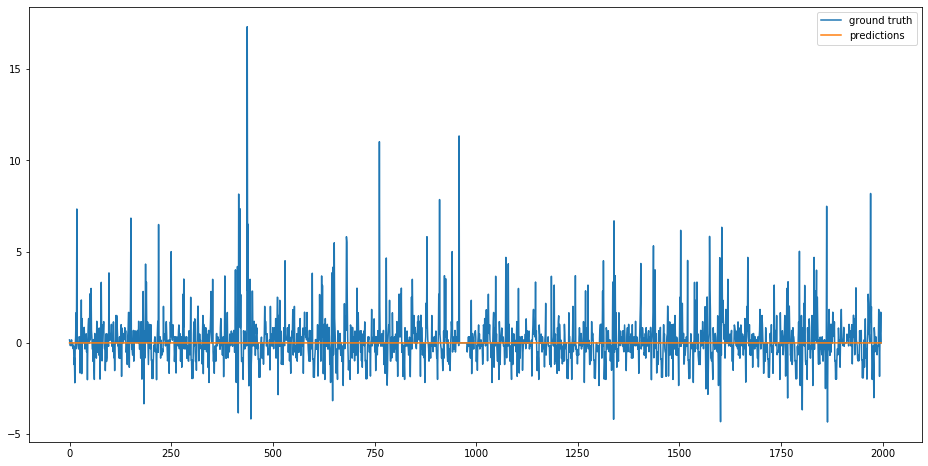

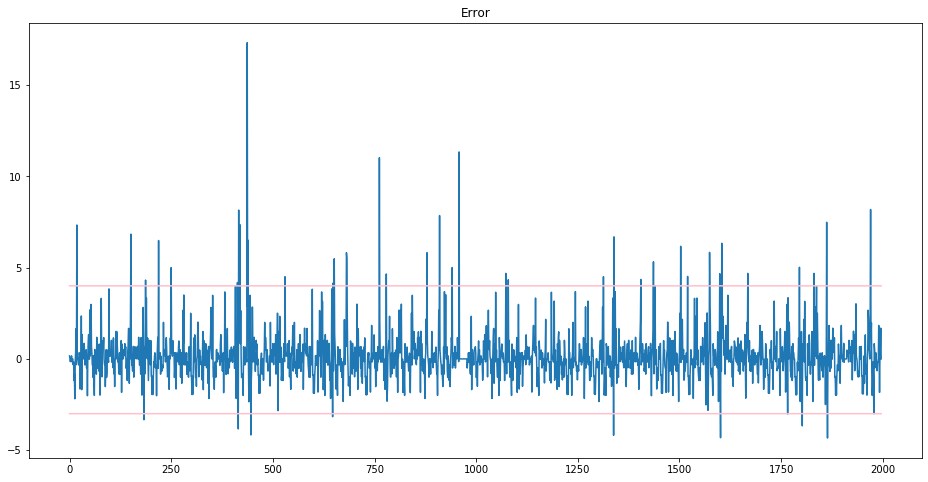

In [51]:
# by plan time
validate_predictions(y_train, np.zeros_like(y_train), _plan_time=X_train.plan_time_to_next_stop)

MSE:  0.28811074262110103
MAE:  0.37323920046181275
MSE when plan_time < 9m:  0.28811074262110103
MAE when plan_time < 9m:  0.37323920046181275
num errors > [-3, 4]m: 0 (0.0%)
num errors > [-3, 4]m when plan time < 9m: 0 (0.0%)


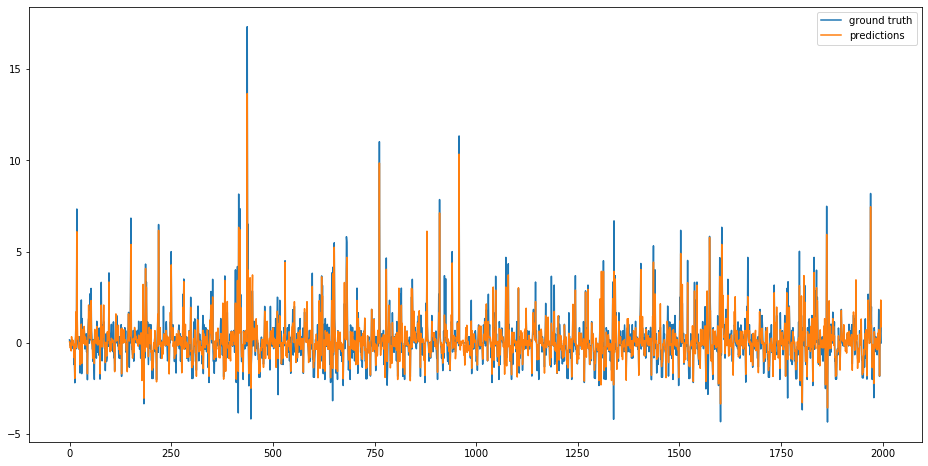

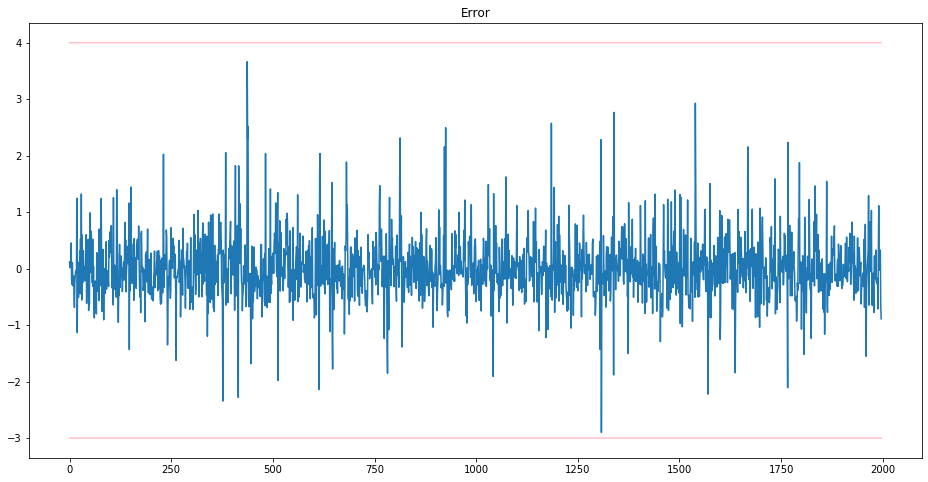

In [119]:
# # without fact
validate_predictions(y_train, pred_train, _plan_time=X_train.plan_time_to_next_stop)

MSE:  0.08527742089409945
MAE:  0.2230586438729309
MSE when plan_time < 9m:  0.08527742089409945
MAE when plan_time < 9m:  0.2230586438729309
num errors > [-3, 4]m: 0 (0.0%)
num errors > [-3, 4]m when plan time < 9m: 0 (0.0%)


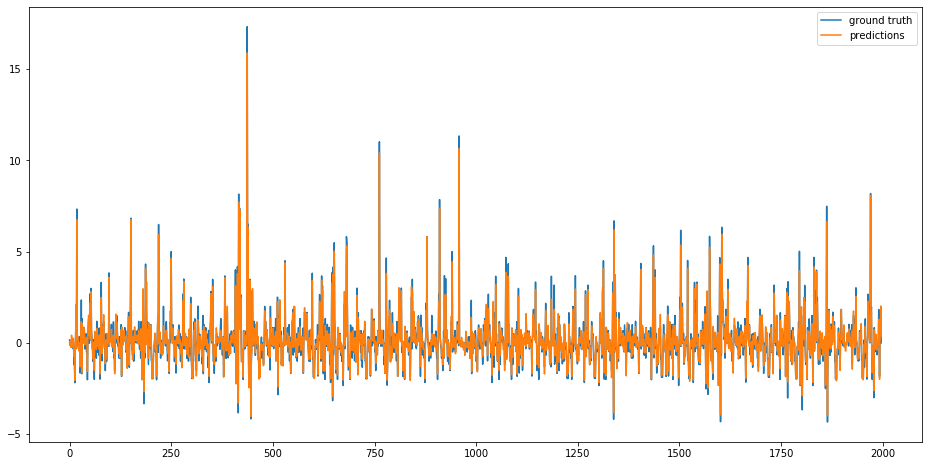

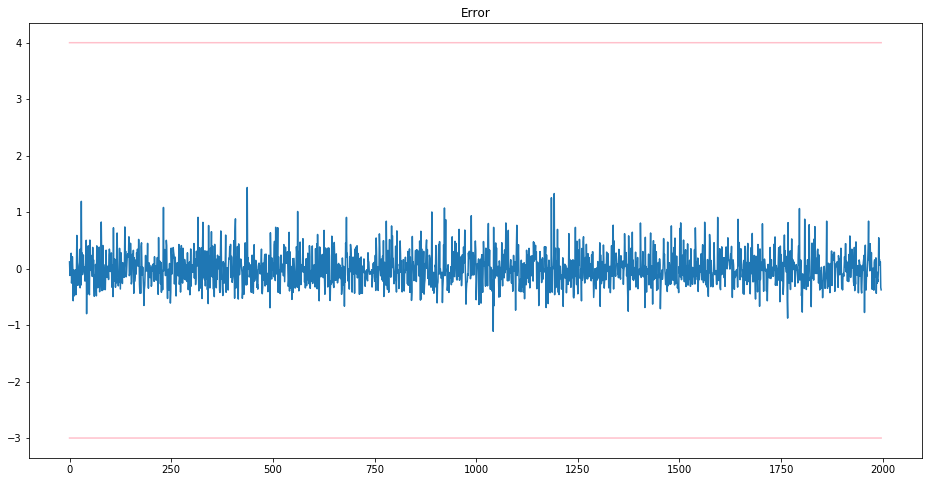

In [53]:
# # without fact
validate_predictions(y_train, pred_train, _plan_time=X_train.plan_time_to_next_stop)

MSE:  0.08527742089409945
MAE:  0.2230586438729309
MSE when plan_time < 9m:  0.08527742089409945
MAE when plan_time < 9m:  0.2230586438729309
num errors > [-3, 4]m: 0 (0.0%)
num errors > [-3, 4]m when plan time < 9m: 0 (0.0%)


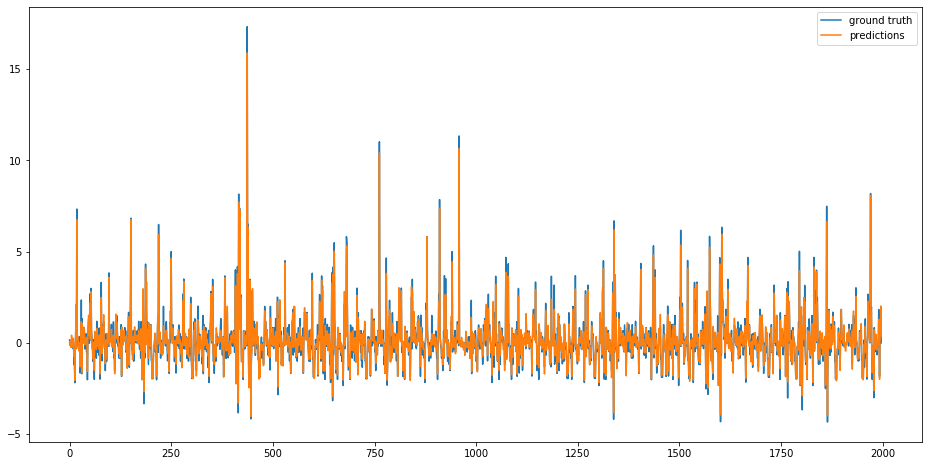

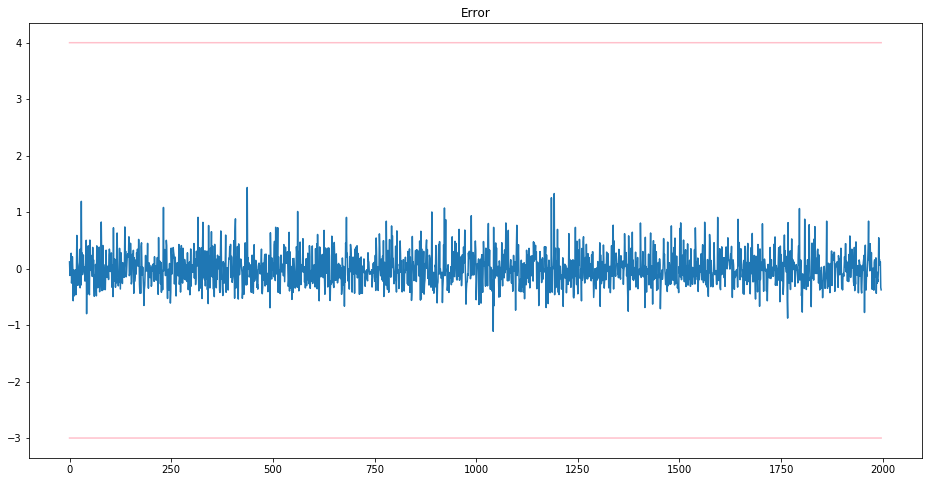

In [54]:
# with fact 
validate_predictions(y_train, pred_train, _plan_time=X_train.plan_time_to_next_stop)

MSE:  0.866172682497699
MAE:  0.532534887753387
MSE when plan_time < 9m:  0.866172682497699
MAE when plan_time < 9m:  0.532534887753387
num errors > [-3, 4]m: 31 (1.6%)
num errors > [-3, 4]m when plan time < 9m: 31 (1.6%)


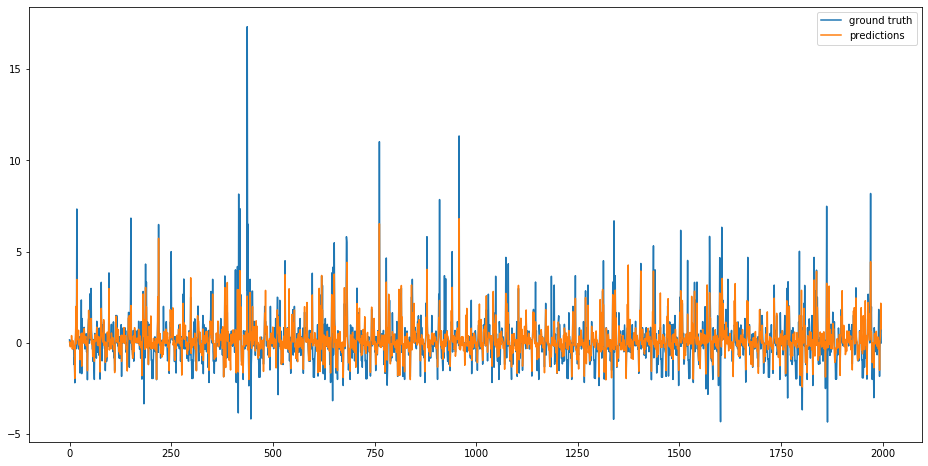

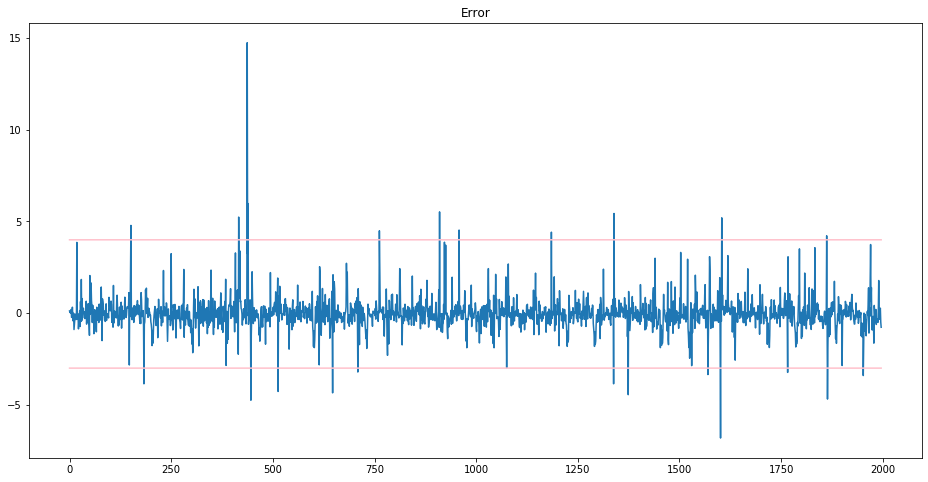

In [55]:
# with fact by one
validate_predictions(y_train, pred_train_by_one, _plan_time=X_train.plan_time_to_next_stop)

## Test day1 

MSE:  1.8566568627450983
MAE:  0.7596732026143791
MSE when plan_time < 9m:  1.8566568627450983
MAE when plan_time < 9m:  0.7596732026143791
num errors > [-3, 4]m: 4 (1.6%)
num errors > [-3, 4]m when plan time < 9m: 4 (1.6%)


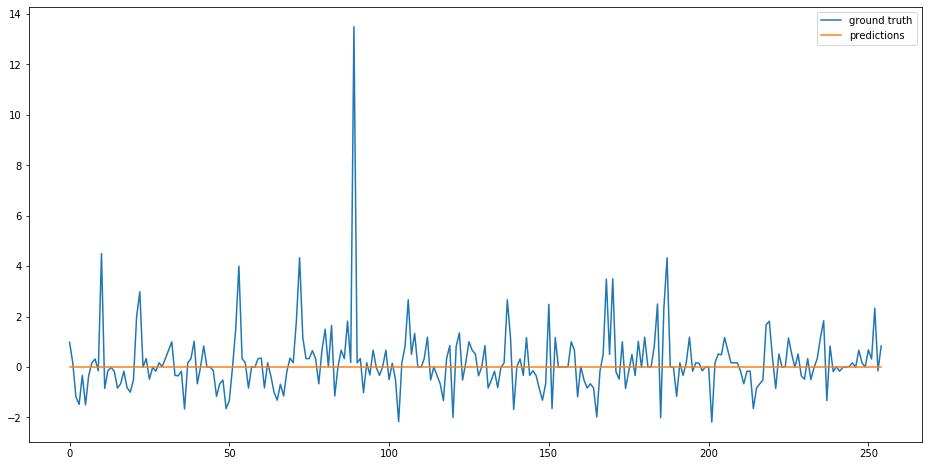

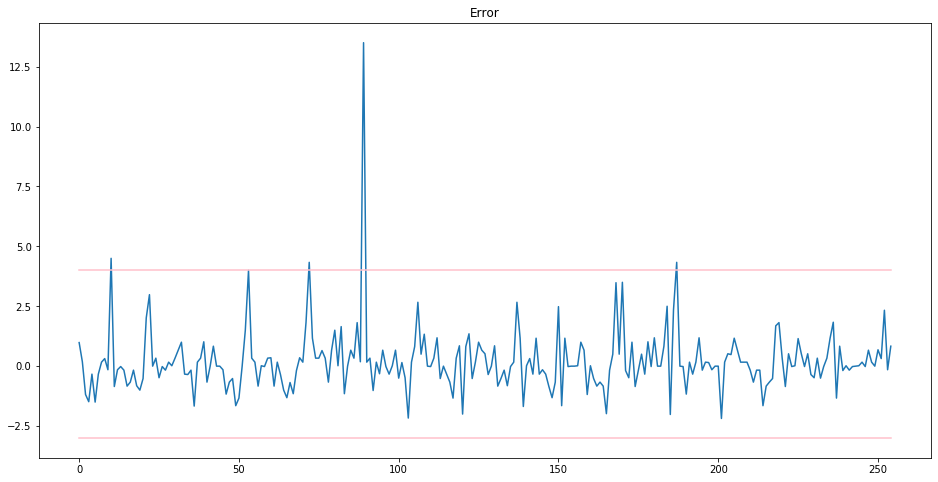

In [65]:
# by plan time
validate_predictions(y_test[:t1], np.zeros(len(y_test[:t1])), _plan_time=X_test.plan_time_to_next_stop[:t1])

MSE:  1.5870902739118868
MAE:  0.6625604663029605
MSE when plan_time < 9m:  1.5870902739118868
MAE when plan_time < 9m:  0.6625604663029605
num errors > [-3, 4]m: 5 (2.0%)
num errors > [-3, 4]m when plan time < 9m: 5 (2.0%)


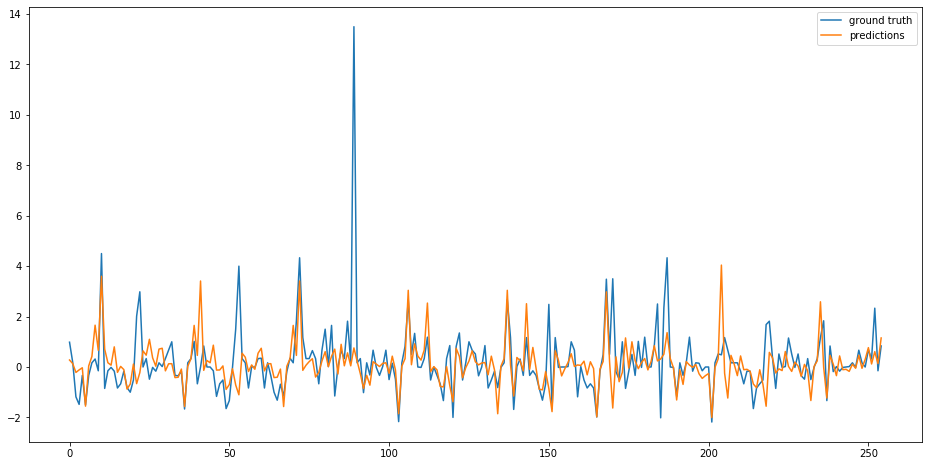

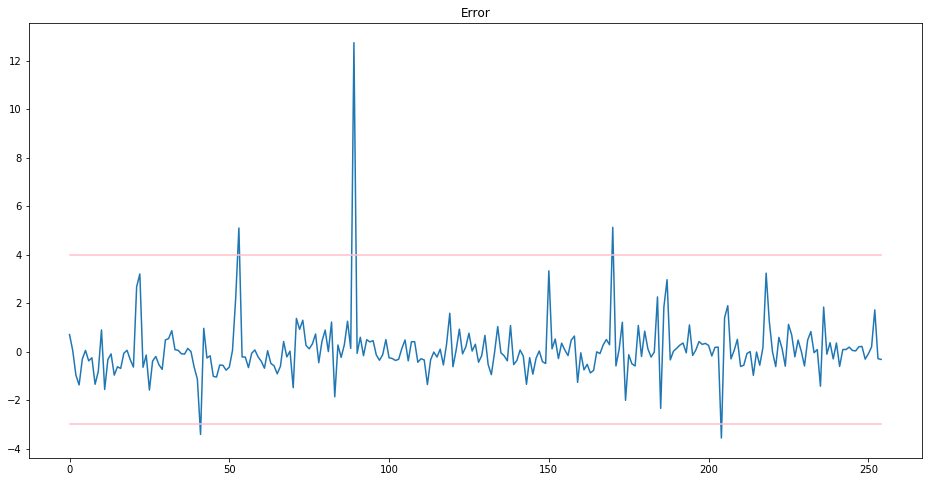

In [120]:
# # without fact
validate_predictions(y_test[:t1], pred_test1, _plan_time=X_test.plan_time_to_next_stop[:t1])

MSE:  1.6136940247649034
MAE:  0.6819782567036404
MSE when plan_time < 9m:  1.6136940247649034
MAE when plan_time < 9m:  0.6819782567036404
num errors > [-3, 4]m: 3 (1.2%)
num errors > [-3, 4]m when plan time < 9m: 3 (1.2%)


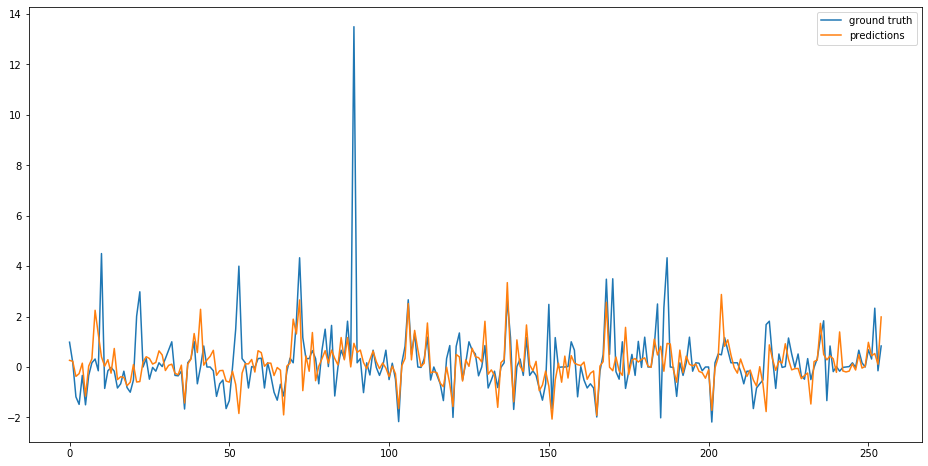

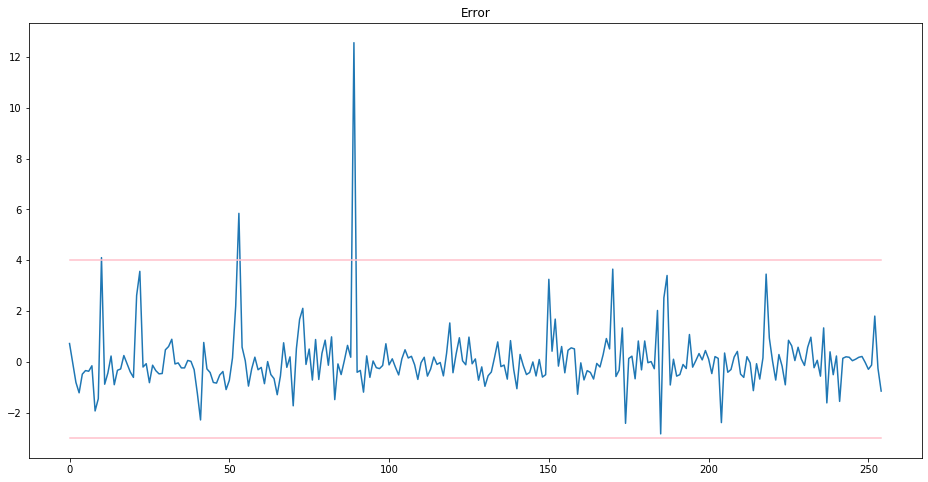

In [67]:
# with fact 
validate_predictions(y_test[:t1], pred_test1, _plan_time=X_test.plan_time_to_next_stop[:t1])

MSE:  1.4911966216054553
MAE:  0.665462267059632
MSE when plan_time < 9m:  1.4911966216054553
MAE when plan_time < 9m:  0.665462267059632
num errors > [-3, 4]m: 3 (1.2%)
num errors > [-3, 4]m when plan time < 9m: 3 (1.2%)


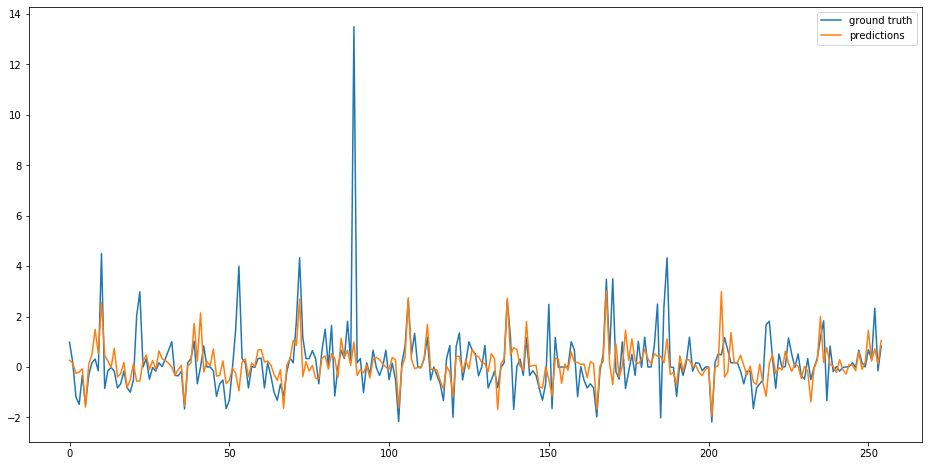

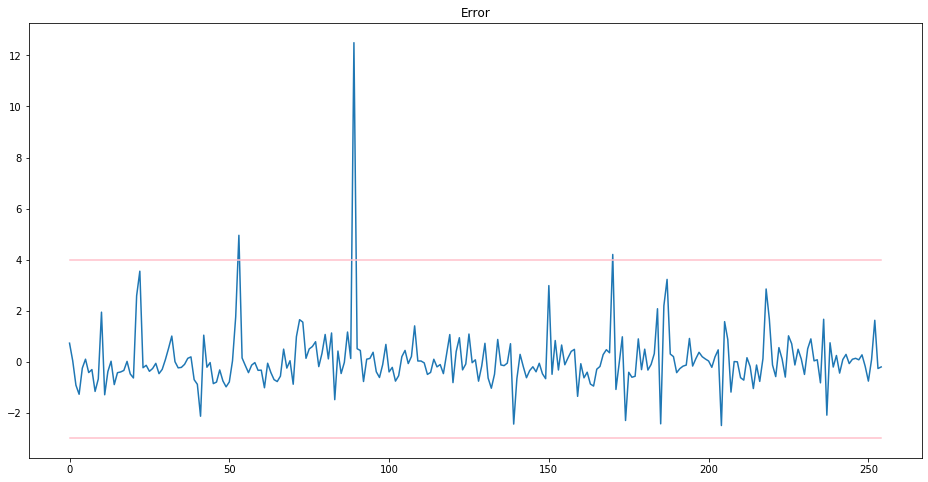

In [68]:
# with fact by one
validate_predictions(y_test[:t1], pred_test_by_one1, _plan_time=X_test.plan_time_to_next_stop[:t1])

### Test day 2

MSE:  1.4249496882086166
MAE:  0.7406037414965986
MSE when plan_time < 9m:  1.4249496882086166
MAE when plan_time < 9m:  0.7406037414965986
num errors > [-3, 4]m: 9 (2.3%)
num errors > [-3, 4]m when plan time < 9m: 9 (2.3%)


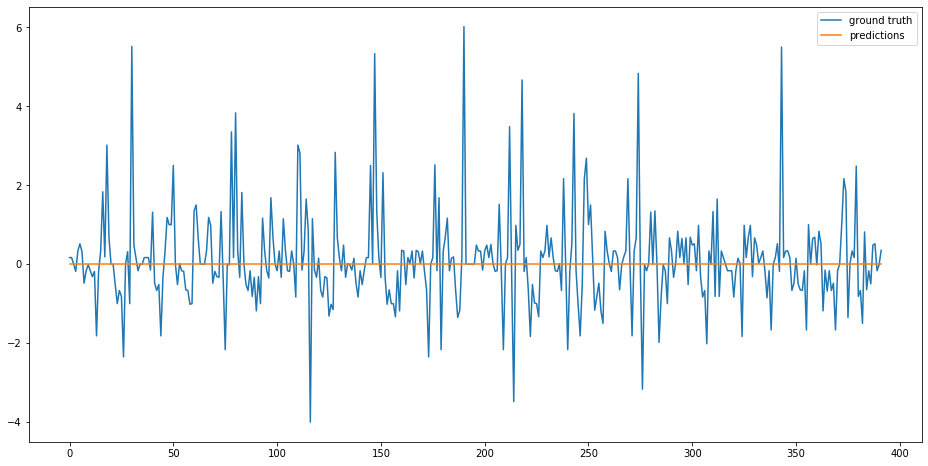

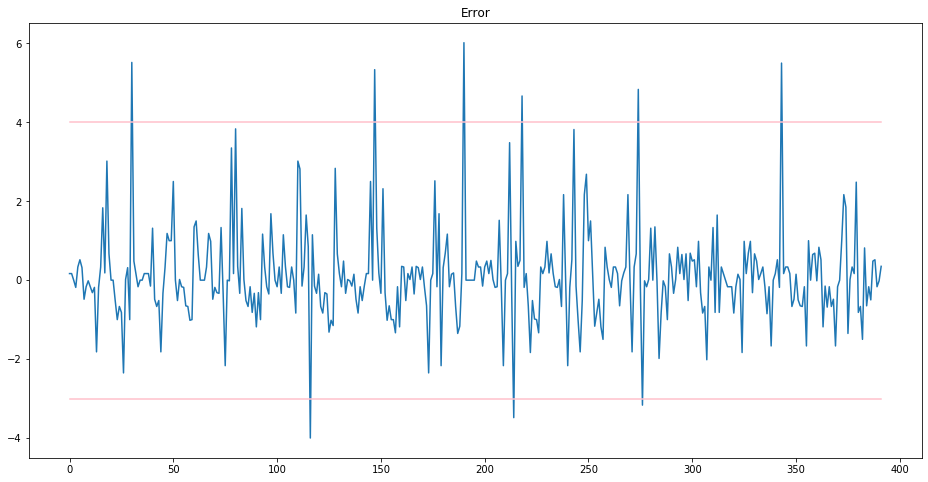

In [69]:
# by plan time
validate_predictions(y_test[t1:], np.zeros(len(y_test))[t1:], _plan_time=X_test.plan_time_to_next_stop[t1:])

MSE:  1.1001352758069887
MAE:  0.6282309294747467
MSE when plan_time < 9m:  1.1001352758069887
MAE when plan_time < 9m:  0.6282309294747467
num errors > [-3, 4]m: 6 (1.5%)
num errors > [-3, 4]m when plan time < 9m: 6 (1.5%)


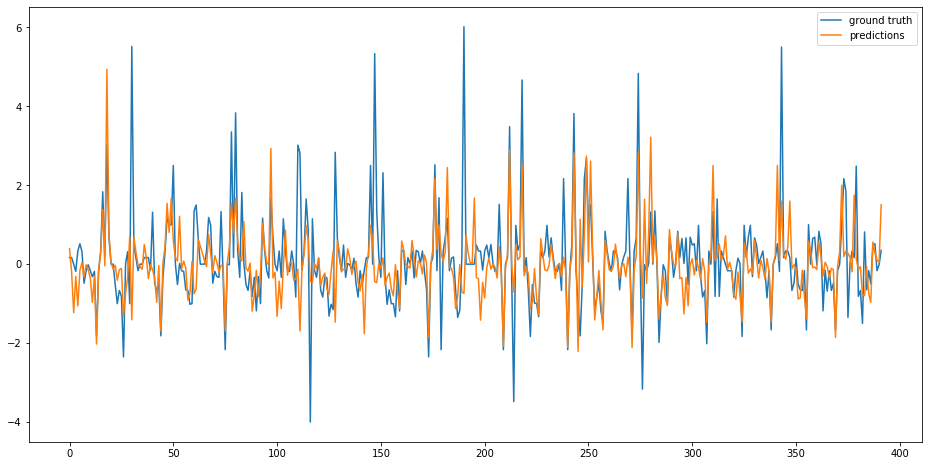

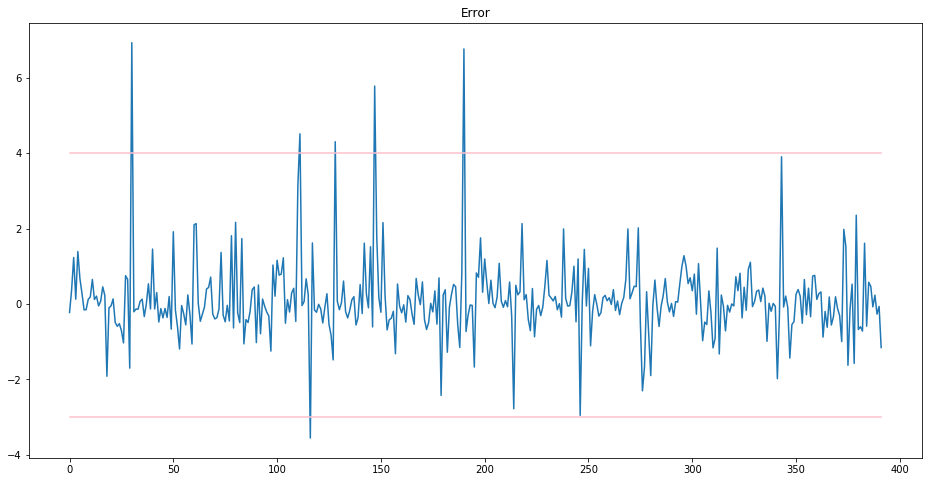

In [121]:
# # without fact
validate_predictions(y_test[t1:], pred_test2, _plan_time=X_test.plan_time_to_next_stop[t1:])

MSE:  1.1157581767642093
MAE:  0.60172809331015
MSE when plan_time < 9m:  1.1157581767642093
MAE when plan_time < 9m:  0.60172809331015
num errors > [-3, 4]m: 7 (1.8%)
num errors > [-3, 4]m when plan time < 9m: 7 (1.8%)


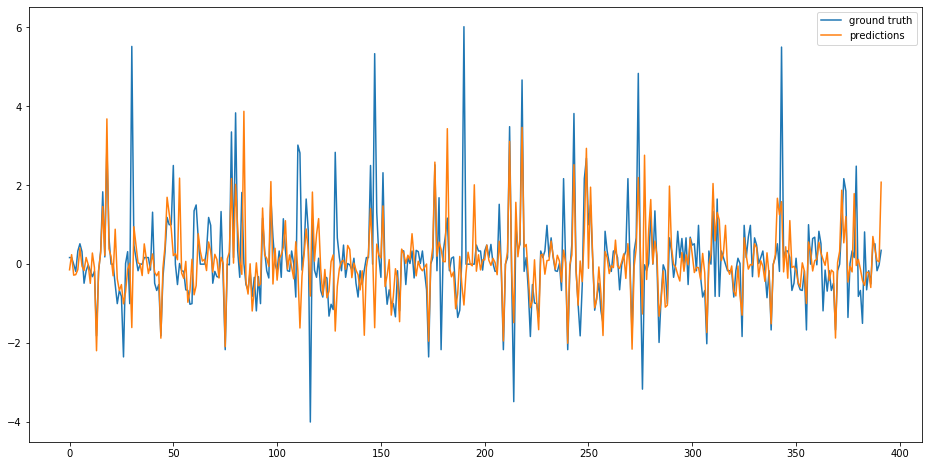

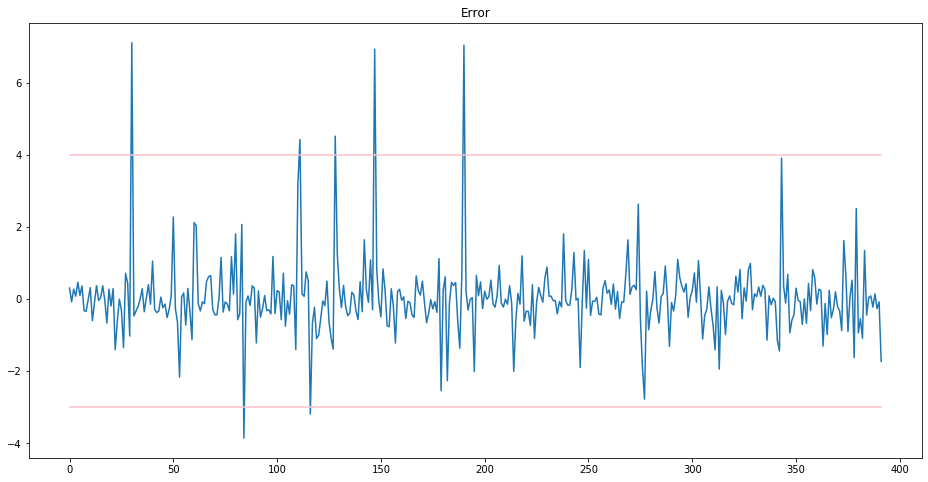

In [71]:
# with fact 
validate_predictions(y_test[t1:], pred_test2, _plan_time=X_test.plan_time_to_next_stop[t1:])

MSE:  1.0486274860802376
MAE:  0.584379880943852
MSE when plan_time < 9m:  1.0486274860802376
MAE when plan_time < 9m:  0.584379880943852
num errors > [-3, 4]m: 6 (1.5%)
num errors > [-3, 4]m when plan time < 9m: 6 (1.5%)


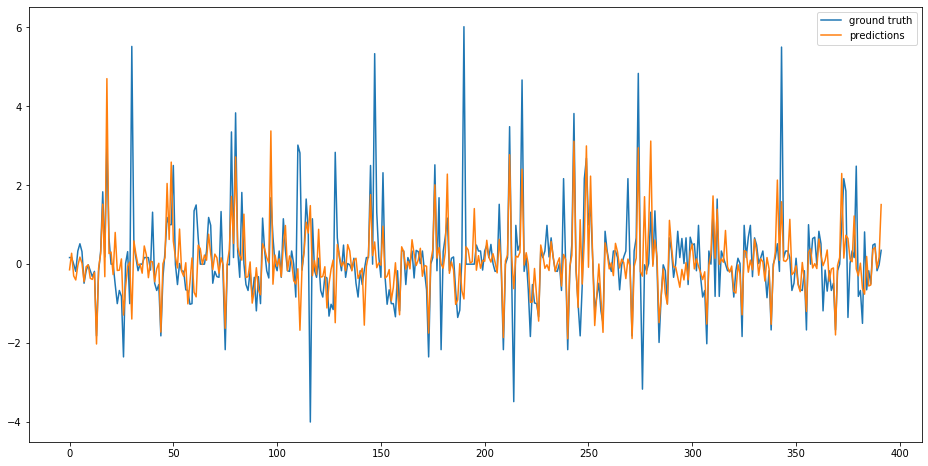

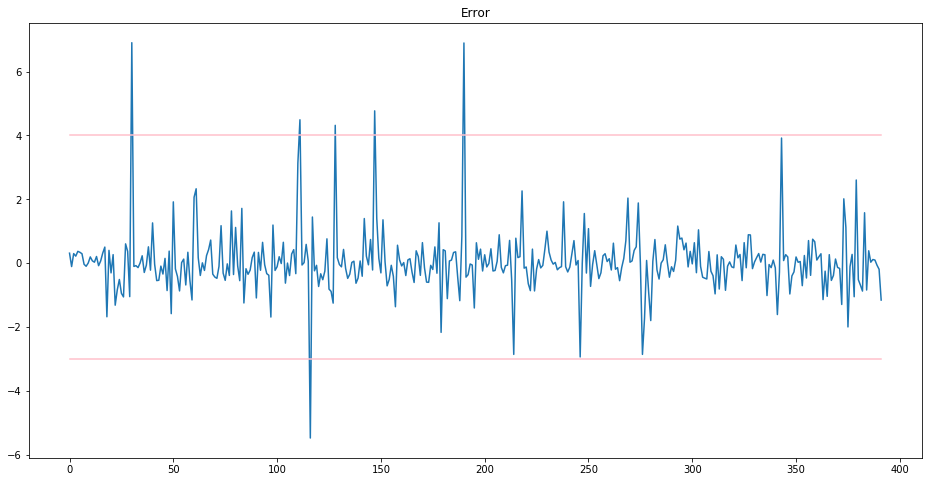

In [73]:
# with fact by one
validate_predictions(y_test[t1:], pred_test_by_one2, _plan_time=X_test.plan_time_to_next_stop[t1:])

In [74]:
list(zip(X_train.columns, model.feature_importances_))

[('plan_time_to_next_stop', 0.015765354),
 ('is_weekend', 0.0),
 ('is_holiday', 0.0),
 ('date_0', 0.0),
 ('date_1', 0.0),
 ('date_2', 0.0045179045),
 ('date_3', 0.016217623),
 ('date_4', 0.004378578),
 ('date_5', 0.013793639),
 ('date_6', 0.010622695),
 ('date_7', 0.007395205),
 ('date_8', 0.008638259),
 ('date_9', 0.008495397),
 ('date_10', 0.002178945),
 ('date_11', 0.010318908),
 ('time_bin_0', 0.0),
 ('time_bin_1', 0.008172625),
 ('time_bin_2', 0.006064301),
 ('time_bin_3', 0.011395202),
 ('time_bin_4', 0.014737527),
 ('time_bin_5', 0.009374289),
 ('time_bin_6', 0.003900303),
 ('time_bin_7', 0.0),
 ('time_bin_8', 0.019035403),
 ('time_bin_9', 0.008136835),
 ('time_bin_10', 0.017508794),
 ('stop_number_0', 0.0054748193),
 ('stop_number_1', 0.0057502254),
 ('stop_number_2', 0.007889146),
 ('stop_number_3', 0.0033387558),
 ('stop_number_4', 0.0059408452),
 ('stop_number_5', 0.012731395),
 ('stop_number_6', 0.007895002),
 ('stop_number_7', 0.0056018545),
 ('stop_number_8', 0.0011174036

### Analyze errors

In [81]:
err_train_df = df_sample.loc[train[(pred_train - y_train >= 4 * 60) | (pred_train - y_train <= -3 * 60)].index]
err_test_df1 = df_sample.loc[test1[(pred_test1 - y_test[:t1] >= 4 * 60) | (pred_test1 - y_test[:t1] <= -3 * 60)].index]
err_test_df2 = df_sample.loc[test2[(pred_test2 - y_test[t1:] >= 4 * 60) | (pred_test2 - y_test[t1:] <= -3 * 60)].index]


In [102]:
err_test_df1.head()

order_uuid  \
19   aa7badb2-2472-11eb-a7e7-02f42b90d40c   
31   aa7badb2-2472-11eb-a7e7-02f42b90d40c   
63   aa7badb2-2472-11eb-a7e7-02f42b90d40c   
100  aa7badb2-2472-11eb-a7e7-02f42b90d40c   
164  aa7badb2-2472-11eb-a7e7-02f42b90d40c   

                     order_execution_uuid  \
19   aadd8654-2472-11eb-8216-02f42b90d40c   
31   ab795a5c-2472-11eb-8607-02f42b90d40c   
63   ac84d4e4-2472-11eb-aa12-02f42b90d40c   
100  adf9a476-2472-11eb-a96f-02f42b90d40c   
164  afd7398e-2472-11eb-8fd3-02f42b90d40c   

           order_execution_data_item_uuid  \
19   ab6b54d4-2472-11eb-9df9-02f42b90d40c   
31   abe293d2-2472-11eb-bb48-02f42b90d40c   
63   ace5bfe8-2472-11eb-bfe4-02f42b90d40c   
100  ae1a37cc-2472-11eb-b119-02f42b90d40c   
164  b0393f62-2472-11eb-8d72-02f42b90d40c   

                               route_uuid  \
19   243289fe-ec14-11e7-9143-fd1bc5b80199   
31   243289fe-ec14-11e7-9143-fd1bc5b80199   
63   243289fe-ec14-11e7-9143-fd1bc5b80199   
100  243289fe-ec14-11e7-9143-fd1bc5b80199   
164  243289fe-ec14-11e7-9143-fd1bc5b80199   

                                            route_name  \
19   Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
31   Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
63   Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
100  Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   
164  Химки (ул. Дружбы) - Москва (м. Речной вокзал)(И)   

                             vehicle_uuid                type  turn  \
19   84b21508-ce8f-11e7-b61c-91326936c687  production_forward    16   
31   84b21508-ce8f-11e7-b61c-91326936c687  production_reverse    16   
63   84b21508-ce8f-11e7-b61c-91326936c687  production_reverse    16   
100  84b21508-ce8f-11e7-b61c-91326936c687  production_forward    16   
164  84b21508-ce8f-11e7-b61c-91326936c687  production_reverse    16   

                                type_uuid  longitude  ...        time_plan_ts  \
19   53e2e4ec-eb4b-11e7-9aae-5d718ddedfcf  37.474025  ... 2020-11-15 08:16:00   
31   22c39fcc-eb47-11e7-9fcf-497e33472986  37.409526  ... 2020-11-15 08:49:00   
63   22c39fcc-eb47-11e7-9fcf-497e33472986  37.409526  ... 2020-11-15 10:10:00   
100  25b5b0d0-eb47-11e7-ad72-b3d3ebe2afff  37.414879  ... 2020-11-15 11:25:00   
164  22b3c67e-eb47-11e7-b135-4da0b7016f80  37.410475  ... 2020-11-15 17:13:00   

           time_fact_ts time_bin weekday is_holiday is_weekend stop_number  \
19  2020-11-15 08:11:41      6-8       6          0          0          19   
31  2020-11-15 08:46:01      6-8       6          0          0          31   
63  2020-11-15 10:06:00     8-10       6          0          0          31   
100 2020-11-15 11:33:01    10-12       6          0          0          34   
164 2020-11-15 17:11:01    16-18       6          0          0          30   

    plan_time_to_next_stop  fact_time_to_next_stop  time_off  
19                   300.0                   570.0     270.0  
31                   120.0                   299.0     179.0  
63                   120.0                   360.0     240.0  
100                   60.0                   870.0     810.0  
164                  120.0                   269.0     149.0  

[5 rows x 24 columns]

In [94]:
err_test_df1['time_off'] = err_test_df1.fact_time_to_next_stop - err_test_df1.plan_time_to_next_stop
err_test_df1[['plan_time_to_next_stop', 'fact_time_to_next_stop', 'time_off', 'stop_number', 'weekday', 'time_bin', 'latitude', 'longitude', 'date']]


plan_time_to_next_stop  fact_time_to_next_stop  time_off  stop_number  \
19                    300.0                   570.0     270.0           19   
31                    120.0                   299.0     179.0           31   
63                    120.0                   360.0     240.0           31   
100                    60.0                   870.0     810.0           34   
164                   120.0                   269.0     149.0           30   
185                   180.0                   390.0     210.0           19   
202                    60.0                   320.0     260.0           34   
235                   120.0                   221.0     101.0           31   

    weekday time_bin   latitude  longitude        date  
19        6      6-8  55.854356  37.474025  2020-11-15  
31        6      6-8  55.897640  37.409526  2020-11-15  
63        6     8-10  55.897640  37.409526  2020-11-15  
100       6    10-12  55.902663  37.414879  2020-11-15  
164       6    16-18  55.894918  37.410475  2020-11-15  
185       6    16-18  55.854356  37.474025  2020-11-15  
202       6    16-18  55.902663  37.414879  2020-11-15  
235       6    20-22  55.897640  37.409526  2020-11-15

In [97]:
err_test_df2['time_off'] = err_test_df2.fact_time_to_next_stop - err_test_df2.plan_time_to_next_stop
err_test_df2[['plan_time_to_next_stop', 'fact_time_to_next_stop', 'time_off', 'stop_number', 'weekday', 'time_bin', 'latitude', 'longitude', 'date']]


plan_time_to_next_stop  fact_time_to_next_stop  time_off  stop_number  \
305                   120.0                   451.0     331.0           31   
388                   120.0                   301.0     181.0           12   
389                   240.0                   409.0     169.0           13   
407                   120.0                   290.0     170.0           31   
427                   300.0                   620.0     320.0           19   
471                    60.0                   421.0     361.0           31   
631                   240.0                   570.0     330.0           19   

    weekday time_bin   latitude  longitude        date  
305       0      4-6  55.897640  37.409526  2020-11-16  
388       0     8-10  55.885193  37.440183  2020-11-16  
389       0     8-10  55.878825  37.448148  2020-11-16  
407       0    10-12  55.897640  37.409526  2020-11-16  
427       0    10-12  55.854356  37.474025  2020-11-16  
471       0    12-14  55.897640  37.409526  2020-11-16  
631       0    22-24  55.854356  37.474025  2020-11-16

In [85]:
err_train_df[['time_plan_ts', 'time_fact_ts', 'stop_number', 'weekday', 'time_bin', 'latitude', 'longitude', 'date']]

Empty DataFrame
Columns: [time_plan_ts, time_fact_ts, stop_number, weekday, time_bin, latitude, longitude, date]
Index: []

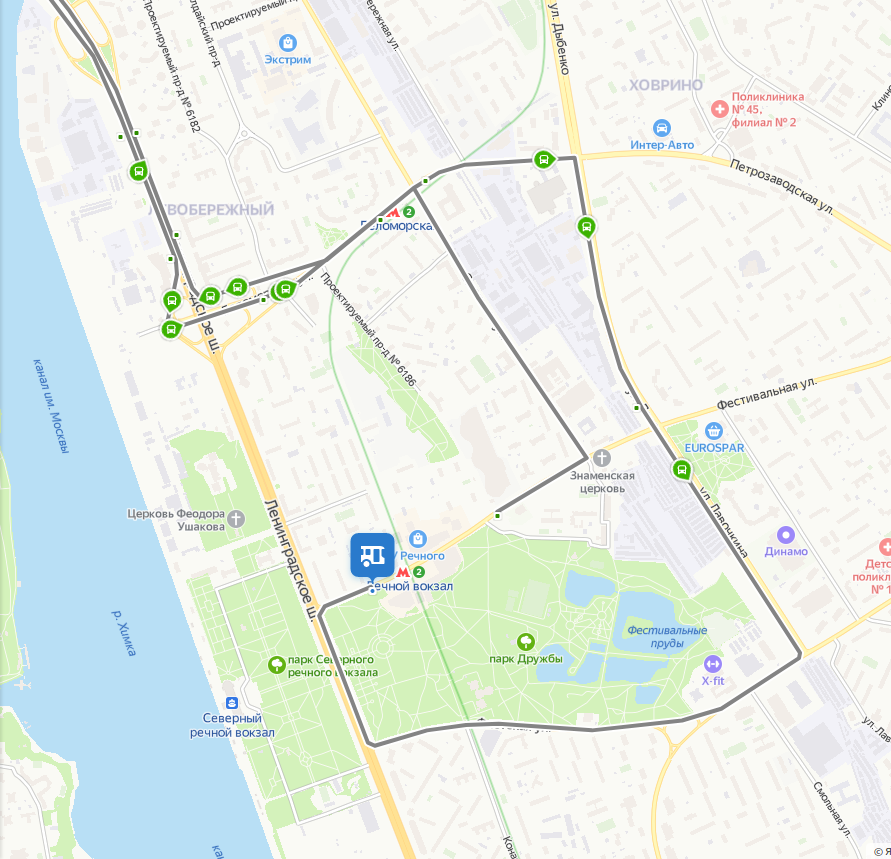

In [104]:
from IPython import display 
display.Image("data/images/1.png")

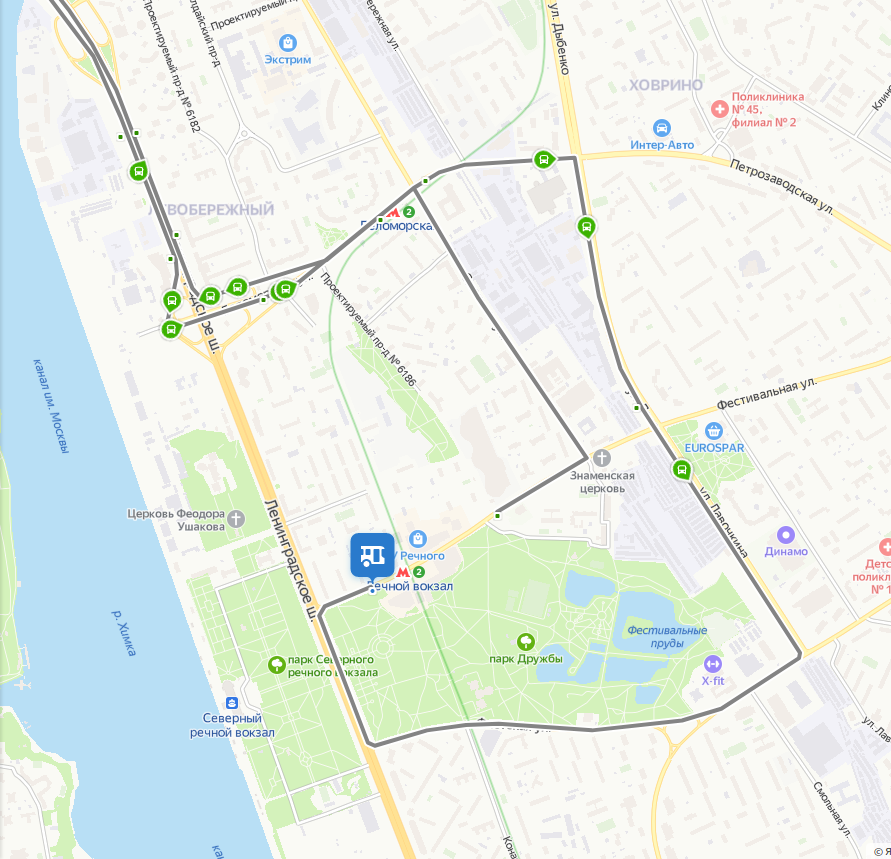

In [105]:
display.Image("data/images/1.png")